### Preprocessing

In [25]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as Data
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
print(train.columns)

Index(['filename', 'width', 'height', 'label', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')


In [2]:
print(test.head())

                     filename  width  height label  xmin  ymin  xmax  ymax
0  0602623232127-web-tete.jpg   1280     720   bad   134    84   220   166
1  0602623232127-web-tete.jpg   1280     720   bad   420    16   460    63
2  0602623232127-web-tete.jpg   1280     720   bad   610    26   656    77
3  0602623232127-web-tete.jpg   1280     720  good   651    43   720   124
4  0602623232127-web-tete.jpg   1280     720   bad   454   106   531   173


In [3]:
import os
def read_directory(directory_name,target):
    array_of_img=[]
    # this loop is for read each image in this foder,directory_name is the foder name with images.
    for i in range(len(target['filename'])):
        img = cv2.imread(directory_name + "/" + target['filename'][i])
        #print(img.shape)
        #print(target['filename'][i])
        IMAGE = img[target['ymin'][i]:target['ymax'][i],target['xmin'][i]:target['xmax'][i],:]
        #print(IMAGE.shape)
        array_of_img.append(IMAGE)
    return array_of_img

In [4]:
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()
    #plt.savefig("test.jpg")
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()
def processing(data):
    # loading image
    # Getting 3 images to work with
    dim =(64,64)
    res_img=[]
    for img in data:
        res = cv2.resize(img, dim, interpolation=cv2.INTER_LINEAR)
        res_img.append(res)

    # Visualizing one of the images in the array
    #original = res_img[1]
    #display_one(original)
    return res_img

In [5]:
def denoise(res_img):
    no_noise = []
    for img in (res_img):
        blur = cv2.GaussianBlur(img, (5, 5), 0)
        no_noise.append(blur)
    image = no_noise[1]
    #display(original, image, 'Original', 'Blured')
    return no_noise

In [6]:
bad=[i for i,x in enumerate(train.label) if x=='bad']
good=[i for i,x in enumerate(train.label) if x=='good']
none=[i for i,x in enumerate(train.label) if x=='none']
a=sum(train.label=='bad')
b=sum(train.label=='good')
c=sum(train.label=='none')
print("Good :{},Bad :{},None :{}".format(b,a,c))

Good :2846,Bad :578,None :104


In [7]:
def noisy(low_data):
    mean = 0
    var = 1
    sigma = var**0.5
    noise=[]
    for img in low_data:
        row,col,ch= img.shape
        gauss = np.random.normal(loc=0,scale=1,size = (row,col,ch))
        img=img/255.0
        gaussian_img = np.clip((img*(1+gauss*0.2)),0,1)
        gaussian_img = gaussian_img*255
        noise.append(gaussian_img)
    return noise

In [8]:
def rotate(data):
    rotate_left=[]
    rotate_right=[]
    for img in data:
        h, w = img.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, -90, 1)
        N = cv2.getRotationMatrix2D(center, 90, 1)
        rotated_img = cv2.warpAffine(img, M, (w, h))
        rotated_img_2 = cv2.warpAffine(img, M, (w, h))
        rotate_left.append(rotated_img_2)
        rotate_right.append(rotated_img)
    return rotate_left,rotate_right

In [32]:
labels=np.zeros((len(train),3))
for i,x in enumerate(train.label):
    if x =='good':
        labels[i][0]=1
    elif x=='bad':
        labels[i][1]=1
    else :
        labels[i][2]=1
bad_labels=np.zeros((len(bad),3))
for i in range (len(bad_labels)):
    bad_labels[i][1]=1
none_labels=np.zeros((len(none),3))
for i in range (len(none_labels)):
    none_labels[i][1]=1

In [11]:
x_ = read_directory('images',train)
x_pro=processing(x_)
x_den=denoise(x_pro)
bad_data=[x_pro[x] for x in bad]
bad_noise=noisy(bad_data)
none_data=[x_pro[x] for x in none]
none_noise=noisy(none_data)
x_bad_noises = np.array(bad_noise,dtype=int)
x_none_noises = np.array(none_noise,dtype=int)
left,right=rotate(bad_data)
left_none,right_none = rotate(none_data)

In [44]:
de_none=np.array([x_den[x]for x in none])
data1=np.array(x_pro)
data2=np.array(x_den)
data3=(x_bad_noises)
data4=np.array(right)
data5=np.array(left)
data6=np.array(right_none)
data7=np.array(left_none)
data8=x_none_noises
#data = np.concatenate([data1,data3,data4,data5,de_none,data6,data7,data8])
#label= np.concatenate([labels,bad_labels,bad_labels,bad_labels,none_labels,none_labels,none_labels,none_labels])
data = data1
label = labels
print(len(data),len(label))
#print(type(data),type(label))


3528 3528


### Dataloader

In [45]:
test_ = read_directory('images',test)

test_pro = processing(test_)
labels=np.zeros((len(test),3))
for i,x in enumerate(test.label):
    if x =='good':
        labels[i][0]=1
    elif x=='bad':
        labels[i][1]=1
    else :
        labels[i][2]=1
x=torch.from_numpy(np.array(test_pro))
y=torch.from_numpy(labels)
torch.manual_seed(1)    # reproducible
BATCH_SIZE = 30      # 批训练的数据个数
torch_dataset = Data.TensorDataset(x,y)
test_loader = Data.DataLoader(dataset=torch_dataset,      
    batch_size=BATCH_SIZE,shuffle=True,num_workers=2,)

In [ ]:
print(y[:,0].sum())

In [46]:

x=torch.from_numpy(data)
y=torch.from_numpy(label)
#x = torch.tensor(train['datas'].values)
#y = torch.tensor(train['labels'].values)

torch.manual_seed(1)    # reproducible
BATCH_SIZE = 30      # 批训练的数据个数
torch_dataset = Data.TensorDataset(x,y)
train_loader = Data.DataLoader(dataset=torch_dataset,      
    batch_size=BATCH_SIZE,shuffle=True,num_workers=2,)

### Model 

In [15]:
import torch.nn as nn
import torch
import torch.nn.functional as F

In [35]:
class CNN(nn.Module):  
    def __init__(self):  
        super(CNN, self).__init__()  
        self.conv1 = nn.Sequential( # (1,28,28)  
                     nn.Conv2d(3, 16, kernel_size=3,  
                               stride=1, padding=1), # (16,28,28)  
        # 想要con2d卷積出來的圖片尺寸沒有變化, padding=(kernel_size-1)/2  
                     nn.ReLU(),  
                     nn.MaxPool2d(2), # (16,14,14)  
                     #nn.Dropout2d(0.2)
                     )  
        self.conv2 = nn.Sequential( # (16,14,14)  
                     nn.Conv2d(16, 32, 3, 1, 1), # (32,14,14)  
                     nn.ReLU(),  
                     nn.MaxPool2d(2), # (32,7,7)
                     #nn.Dropout2d(0.1)
                     )
        self.conv3 = nn.Sequential( # (16,14,14)  
                     nn.Conv2d(32, 64, 3, 1, 1), # (32,14,14)  
                     nn.ReLU(),  
                     #nn.AvgPool2d(2), # (32,7,7)
                     nn.MaxPool2d(2),
                     #nn.Dropout2d(0.1)
                     )
        self.out = nn.Linear(4096, 3)  
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x, 1)
        x = self.out(x)
        output = F.log_softmax(x, 1)
        return output

def train_mask(model,train_data, optimizer, epoch,cuda):
    model.train()
    correct = 0
    train_loss = 0
    mts=[]
    for batch_idx, (data, target) in enumerate(train_data):
        if cuda!='cpu':
            data = data.type(torch.FloatTensor)
            target = target.type(torch.LongTensor)
            data, target = data.to(cuda), target.to(cuda)

        data = data.transpose(1,3)#.transpose(2,3)
        #print(data.shape)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()
        loss = loss(output, torch.max(target, 1)[1])
        loss.backward()
        optimizer.step() 
        train_loss +=loss
        pred = output.argmax(dim=1, keepdim=True)
        for i in range(len(pred )):
            if pred[i].item() == torch.max(target, 1)[1][i].item():
                correct+=1
    correct /= len(train_data.dataset)
    train_loss /= len(train_data)
    print('Epoch:', epoch,'|train loss:%.4f'%train_loss.item(),'|train accuracy: %.4f'%correct)
    mts.append([epoch,train_loss.item(),correct])
    return mts
def test_mask(model,test_data,cuda):
    model.eval()
    test_loss = 0
    correct = 0
    mt=[]
    with torch.no_grad():
        for idx,(data, target) in enumerate(test_data):
            #print(target)
            #print(torch.max(target, 1)[1])
            if cuda !='cpu':
                data = data.type(torch.FloatTensor)
                target = target.type(torch.LongTensor)
                data, target = data.to(cuda), target.to(cuda)
            data = data.transpose(1,3)#.transpose(2,3)
            output = model(data)
            loss = nn.CrossEntropyLoss()
            test_loss += loss(output, torch.max(target, 1)[1])  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            #print(pred)
            #print(pred.eq(target).sum())
            #print(pred[0].item(),torch.max(target[0]).item())
            for i in range(len(pred)):
                if pred[i].item() == torch.max(target, 1)[1][i].item():
                    correct+=1
    #print(correct)
    test_loss /= len(test_data)
    correct /= len(test_data.dataset)
    #test_matrix.append([test_loss.item(),correct])
    mt.append([test_loss.item(),correct])
    print('|test loss:%.4f'% test_loss.item(),'|test accuracy: %.4f'% correct)
    return mt

In [47]:
#%store -r train_loader
from torch.optim.lr_scheduler import StepLR
use_cuda = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("use_cuda or not:",use_cuda)
Mask = CNN().to(use_cuda)
optimizer = torch.optim.Adam(Mask.parameters(), lr=0.01)
#critien = nn.CrossEntropyLoss()
lambda1 = lambda epoch: epoch // 30
lambda2 = lambda epoch: 0.95 ** epoch
#scheduler = LambdaLR(optimizer, lr_lambda=[lambda1, lambda2])
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
matrix_epoch=[]
train_matrix=[]
test_matrix=[]   
for epoch in range(100): #每次epoch 都計算train和test的loss
    scheduler.step()
    mt1 = train_mask(Mask,train_loader,optimizer,epoch,use_cuda)
    mt2 = test_mask(Mask, test_loader,use_cuda)
    train_matrix.append(mt1)
    test_matrix.append(mt2)
torch.save(Mask.state_dict(), "mask_cnn_mx_.pkl")

use_cuda or not: cuda:0
Epoch: 0 |train loss:2.9713 |train accuracy: 0.7826
|test loss:0.7523 |test accuracy: 0.7183
Epoch: 1 |train loss:0.3112 |train accuracy: 0.8855
|test loss:0.2675 |test accuracy: 0.9036
Epoch: 2 |train loss:0.2325 |train accuracy: 0.9238
|test loss:0.2933 |test accuracy: 0.9086
Epoch: 3 |train loss:0.1968 |train accuracy: 0.9357
|test loss:0.3396 |test accuracy: 0.8782
Epoch: 4 |train loss:0.2062 |train accuracy: 0.9337
|test loss:0.3284 |test accuracy: 0.8782
Epoch: 5 |train loss:0.2183 |train accuracy: 0.9277
|test loss:0.3804 |test accuracy: 0.8680
Epoch: 6 |train loss:0.2586 |train accuracy: 0.9172
|test loss:0.3000 |test accuracy: 0.9010
Epoch: 7 |train loss:0.2028 |train accuracy: 0.9311
|test loss:0.2586 |test accuracy: 0.9086
Epoch: 8 |train loss:0.2237 |train accuracy: 0.9215
|test loss:0.3101 |test accuracy: 0.8909
Epoch: 9 |train loss:0.1978 |train accuracy: 0.9314
|test loss:0.3749 |test accuracy: 0.9036
Epoch: 10 |train loss:0.1898 |train accuracy: 

|test loss:0.3400 |test accuracy: 0.9086
Epoch: 88 |train loss:0.1325 |train accuracy: 0.9569
|test loss:0.3628 |test accuracy: 0.9061
Epoch: 89 |train loss:0.1315 |train accuracy: 0.9569
|test loss:0.4955 |test accuracy: 0.9061
Epoch: 90 |train loss:0.1315 |train accuracy: 0.9569
|test loss:0.3677 |test accuracy: 0.9061
Epoch: 91 |train loss:0.1314 |train accuracy: 0.9569
|test loss:0.3313 |test accuracy: 0.9061
Epoch: 92 |train loss:0.1319 |train accuracy: 0.9569
|test loss:0.3495 |test accuracy: 0.9061
Epoch: 93 |train loss:0.1313 |train accuracy: 0.9572
|test loss:0.3325 |test accuracy: 0.9061
Epoch: 94 |train loss:0.1318 |train accuracy: 0.9575
|test loss:0.3713 |test accuracy: 0.9061
Epoch: 95 |train loss:0.1311 |train accuracy: 0.9572
|test loss:0.3528 |test accuracy: 0.9061
Epoch: 96 |train loss:0.1316 |train accuracy: 0.9572
|test loss:0.3362 |test accuracy: 0.9061
Epoch: 97 |train loss:0.1309 |train accuracy: 0.9575
|test loss:0.3526 |test accuracy: 0.9061
Epoch: 98 |train lo

In [37]:
train_loss=[]
train_acc=[]
for mt in train_matrix:
    for z,s,c in mt:
        train_loss.append(s)
        train_acc.append(c)
train_loss=np.array(train_loss)
train_acc=np.array(train_acc)
test_loss=[]
test_acc=[]
for mt in test_matrix:
    for z,s in mt:
        test_loss.append(z)
        test_acc.append(s)
test_loss=np.array(test_loss)
test_acc=np.array(test_acc)
#print(train_loss)

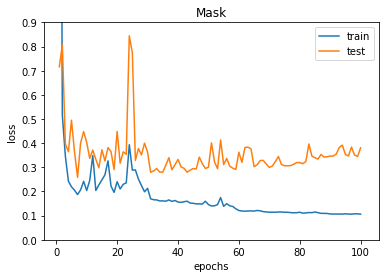

In [38]:
fig = plt.figure()
plt.ylim(0, 0.9)
#for key,value in data_dict.items():
plt.plot(range(1,len(train_loss)+1), train_loss,label='train')
plt.plot(range(1,len(test_loss)+1), test_loss,label='test')
plt.legend(loc='best')
plt.title("Mask")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.hlines([50,105], 1, len(train_loss) + 1, linestyles='dashed', colors=(0, 0, 0, 1))
plt.show()

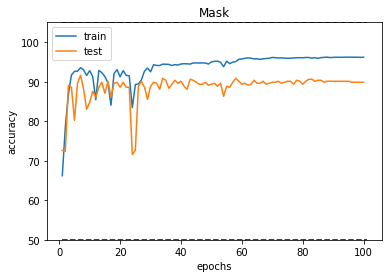

In [39]:
fig = plt.figure()
plt.ylim(50, 105)
#for key,value in data_dict.items():
plt.plot(range(1,len(train_acc)+1), train_acc*100,label='train')
plt.plot(range(1,len(test_acc)+1), test_acc*100,label='test')
plt.legend(loc='best')
plt.title("Mask")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.hlines([50,105], 1, len(train_loss) + 1, linestyles='dashed', colors=(0, 0, 0, 1))
plt.show()

In [48]:
Demo = CNN().to(use_cuda)
paras = torch.load("mask_cnn_mx_.pkl")
Demo.load_state_dict(paras)
def evaluation(data,models,cuda):
    #test_loader = DataLoader(test_dataset, len(test_dataset))
    #keys = ["good","bad","none"]
    #ac_={}
    #for key in keys:
    #    ac_.update({key + "_acc": [] })
    #for _ in range(500):
    gd_good = 0
    gd_bad = 0
    gd_none = 0
    correct_good = 0
    correct_bad = 0
    correct_none = 0
    for _,(data, target) in enumerate(data):
        if cuda !='cpu':
            data = data.type(torch.FloatTensor)
            target = target.type(torch.LongTensor)
            data, target = data.to(cuda), target.to(cuda)
        data = data.transpose(1,3)
        # print(key)
        # models.load_state_dict(torch.load(load_model_name))
        output = models.forward(data)
        pred = output.argmax(dim=1, keepdim=True)
        
        for i in range(len(pred)):
            ground_truth = torch.max(target, 1)[1][i].item()
            if ground_truth == 0:
                gd_good+=1
                if pred[i].item() == ground_truth:
                    correct_good+=1
            elif ground_truth == 1:
                gd_bad+=1
                if pred[i].item() == ground_truth:
                    correct_bad+=1
            else:
                gd_none+=1
                if pred[i].item() == ground_truth:
                    correct_none+=1
        
        #ac_[key[0]+"_acc"].append(correct_good)
        #ac_[key[1]+"_acc"].append(correct_bad)
    print("good_acc: {} , bad_acc: {} , none_acc: {}".format(correct_good / gd_good,correct_bad / gd_bad ,correct_none /gd_none))    
    #return correct_good / gd_good,correct_bad / gd_bad ,correct_none /gd_none

In [ ]:
print(Demo)

In [49]:
evaluation(train_loader,Demo,use_cuda)
evaluation(test_loader,Demo,use_cuda)

good_acc: 0.9736472241742797 , bad_acc: 0.9550173010380623 , none_acc: 0.5288461538461539
good_acc: 0.9399293286219081 , bad_acc: 0.9438202247191011 , none_acc: 0.3181818181818182
